<center>世界重要赛事冰壶数据分析</center>
<center>2020,12,17</center>

#### 这篇笔记将利用之前已经得到的24场世界冰壶协会的赛事数据分析男女运动员投壶策略的差异，在冰壶运动中，男性运动员是否更喜爱进攻，女性运动员更偏爱防守策略呢？
    通过以下字段进行统计学分析：
- shot表里面的shot_type(投掷方式）,如果男女运动员的投壶策略基本相同，那么这个字段在男女运动员之间应该没有很大差异
- "stones in play":如果女性运动员偏爱防守策略，那么每一局比赛场上的留下的冰壶数量应该更多

统计学上采用卡方检验，显著性差异，P<0.05视为有意义。


## 一、投掷方式分析

- 从game表type键获取性别，从shot表中type键中获取投壶方式
- 按现有字段分析：统计每一种投掷方式的性别分布，利用卡方检验，进而比较男女运动员各自喜好的击球方式，但是这并没有直接说明男运动员比女运动员更喜欢把球用“暴力”打出界外
- 按"击打"与"不击打"分类：把现有的投壶方式归为两类,但是这样统计会失去一些细节

两种分析方法各有优劣，因此我们使用两种方法，看看结果会是怎样

In [1]:
# 连接数据库
import os
os.environ["CADBPATH"]=os.getcwd() + "/curling_data.db"

import database_functions as db

In [2]:
q = """
SELECT games.type AS game_type, shots.type AS shot_type FROM games
INNER JOIN ends ON ends.game_id = games.id
INNER JOIN shots ON shots.end_id = ends.id
"""
type_df = db.run_query(q)
type_df

,game_type,shot_type
0,Men,Front
1,Men,Draw
2,Men,Hit and Roll
3,Men,Draw
4,Men,Draw
...,...,...
182770,Women,Double Take-out
182771,Women,Double Take-out
182772,Women,Double Take-out
182773,Women,Draw


In [3]:
# 首先看一下男女运动员分别投壶的总次数
type_df.groupby("game_type").count()

,shot_type
game_type,
Men,95422
Women,87353


    从上表可以看出，男运动员和女运动员的投壶次数差别不大，男运动员要多10%左右，因此在比较的时候需要转化成百分比的形式，卡方检验不需要做标准归一化操作

In [4]:
# 不同类型的投壶次数统计
type_df.groupby("shot_type").count()

,game_type
shot_type,
Clearing,16609
Double Take-out,10354
Draw,57199
Freeze,1434
Front,18719
Guard,10980
Hit and Roll,14656
None,4806
Promotion Take-out,5049


    需要删除一些没有意义的类型：
- None:没有有关数据
- no statistics: 同样没有统计
- not played: 偶尔包括但没有意义的投掷类型，删除
- 此外还需要把'through'换成'Through'，二者是相同的

In [5]:
type_df_clean = type_df[type_df["shot_type"] != "None"]
type_df_clean = type_df_clean[type_df_clean["shot_type"] != "no statistics"]
type_df_clean = type_df_clean[type_df_clean["shot_type"] != "not played"]
type_df_clean = type_df_clean.replace("through", "Through")
type_df_clean.groupby("shot_type").count()

,game_type
shot_type,
Clearing,16609
Double Take-out,10354
Draw,57199
Freeze,1434
Front,18719
Guard,10980
Hit and Roll,14656
Promotion Take-out,5049
Raise,5531


In [6]:
# 清洗过的数据分别统计男女运动员投掷次数
type_df_clean.groupby("game_type").count()

,shot_type
game_type,
Men,93112
Women,84818


**不同的投掷方式:**
- Clearing:击打，把对方的占位壶连同自己清理出场地
- double take-out:又称双飞，用自己一个球，将对方两个球击出大本营
- Draw: 向大本营里放置冰壶
- Freeze:粘球，接触或几乎接触另一只冰壶
- Front:防卫球的一种特殊形式
- Guard:防卫球，位于栏线与大本营之间、用于防卫的投球
- Hit and Roll:打甩，击走一只冰壶，使其离开中心，自己占据目标位置
- Promotion Take-out:传击，击打第一个壶改变方向，然后把第二个壶打出界外
- Raise:传球（例如轻碰占位壶，让占位壶到某一位置）
- Take-out:击走，一种难度较大的击球方式，它使另一球从比赛中去除
- Through: 放球，特殊情况下比如想当后手时使用
- Wick/Soft Peeling: soft peeling 是clearing的减弱版本。 wick轻轻触到一只静止冰壶的运动冰壶，以改变方向

In [7]:
# 添加is_hit字段，将上述几种技术分为2类
hit_types = ["Clearing", "Double Take-out", "Hit and Roll", "Promotion Take-out", "Take-out"]
type_df_clean["is_hit"] = type_df_clean["shot_type"].isin(hit_types)
type_df_clean

,game_type,shot_type,is_hit
0,Men,Front,False
1,Men,Draw,False
2,Men,Hit and Roll,True
3,Men,Draw,False
4,Men,Draw,False
...,...,...,...
182770,Women,Double Take-out,True
182771,Women,Double Take-out,True
182772,Women,Double Take-out,True
182773,Women,Draw,False


### 按现有字段分析

In [8]:
import matplotlib.pyplot as plt

# 将男女分开
men_types = type_df_clean[type_df_clean["game_type"] == "Men"]
women_types = type_df_clean[type_df_clean["game_type"] == "Women"]

# 获取男女投壶总数,标准化
n_men = men_types.shape[0]
n_women = women_types.shape[0]

men_type_percent = 100*men_types.groupby("shot_type")["game_type"].count()/n_men
men_type_percent

shot_type
Clearing                9.629264
Double Take-out         6.269869
Draw                   31.618911
Freeze                  0.610018
Front                  10.784861
Guard                   6.235501
Hit and Roll            8.329753
Promotion Take-out      3.269181
Raise                   3.422760
Take-out               18.254360
Through                 0.514434
Wick / Soft Peeling     1.061088
Name: game_type, dtype: float64

In [9]:
women_type_percent = 100*women_types.groupby("shot_type")["game_type"].count()/n_women
women_type_percent

shot_type
Clearing                9.011059
Double Take-out         5.324342
Draw                   32.726544
Freeze                  1.021010
Front                  10.230140
Guard                   6.100120
Hit and Roll            8.135066
Promotion Take-out      2.363885
Raise                   2.763564
Take-out               20.494471
Through                 0.490462
Wick / Soft Peeling     1.339338
Name: game_type, dtype: float64

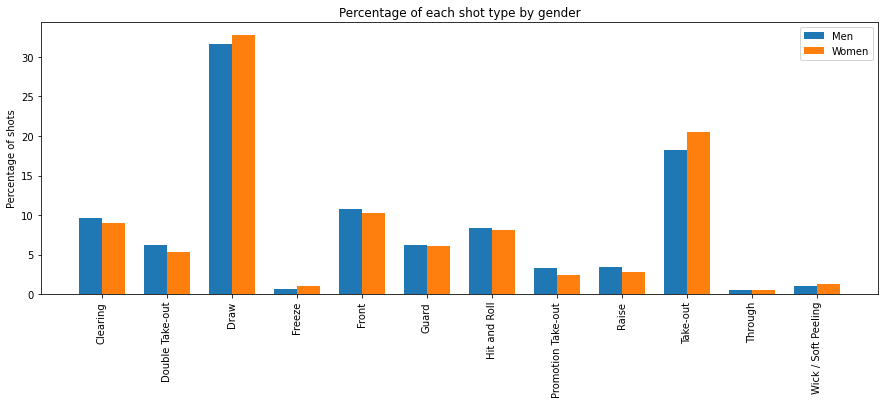

In [10]:
import numpy as np
labels = men_type_percent.index.values
n_labels = len(labels)
men_pct = men_type_percent.values
women_pct = women_type_percent.values

x = np.arange(n_labels)
width = 0.35

# 绘图
fig, ax = plt.subplots(figsize=(15,5))
men_plt = ax.bar(x-width/2, men_pct, width, label='Men')
women_plt = ax.bar(x + width/2, women_pct, width, label = 'Women')

ax.set_ylabel("Percentage of shots")
ax.set_title("Percentage of each shot type by gender")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

    从上图可以看出，不管是哪一种投壶方式，男女之间的比例时都是十分接近，使用Draw和Take-out技术最为普遍，女性运动员的使用百分比更高。
    女性使用take-out的比例更高，男性在clearing,double,promotion take-out上使用率更高，这些都是hit类型技术，而归类hit\no-hit会丢失掉这些信息

In [11]:
# 进行卡方检验
men_type_counts = men_types.groupby("shot_type")["game_type"].count().values
men_type_counts

array([ 8966,  5838, 29441,   568, 10042,  5806,  7756,  3044,  3187,
       16997,   479,   988])

In [12]:
women_type_counts = women_types.groupby("shot_type")["game_type"].count().values
women_type_counts

array([ 7643,  4516, 27758,   866,  8677,  5174,  6900,  2005,  2344,
       17383,   416,  1136])

In [14]:
# 使用chi2_contingency进行计算
from scipy.stats import chi2_contingency

#Make the contingency table out of this data.
cont_table = np.array([men_type_counts, women_type_counts])
cont_table

array([[ 8966,  5838, 29441,   568, 10042,  5806,  7756,  3044,  3187,
        16997,   479,   988],
       [ 7643,  4516, 27758,   866,  8677,  5174,  6900,  2005,  2344,
        17383,   416,  1136]])

In [15]:
chi2_contingency(cont_table)

(547.4835720386225,
 2.3539807626667085e-110,
 11,
 array([[ 8691.60460855,  5418.31983364, 29932.63242848,   750.42212106,
          9795.78220649,  5745.90996459,  7669.58619682,  2642.17663126,
          2894.41056595, 17991.29185635,   468.35969201,  1111.50389479],
        [ 7917.39539145,  4935.68016636, 27266.36757152,   683.57787894,
          8923.21779351,  5234.09003541,  6986.41380318,  2406.82336874,
          2636.58943405, 16388.70814365,   426.64030799,  1012.49610521]]))

    经过列联表的独立性检验（卡方检验）得出P<0.05，因此我们得出结论，男女投壶方式存在显著性差异，尽管在百分比图中差别不是那么明显，这是因为样本总体数目比较庞大，从图上来看，女子男子差异性不大，正常来说冰壶10局比赛，每只队伍会投掷80只壶，如果是男子比赛，那我们的数学期望是：

In [16]:
80*men_type_percent/100

shot_type
Clearing                7.703411
Double Take-out         5.015895
Draw                   25.295128
Freeze                  0.488014
Front                   8.627889
Guard                   4.988401
Hit and Roll            6.663803
Promotion Take-out      2.615345
Raise                   2.738208
Take-out               14.603488
Through                 0.411547
Wick / Soft Peeling     0.848870
Name: game_type, dtype: float64

    对于女子：

In [17]:
80*women_type_percent/100

shot_type
Clearing                7.208847
Double Take-out         4.259473
Draw                   26.181235
Freeze                  0.816808
Front                   8.184112
Guard                   4.880096
Hit and Roll            6.508053
Promotion Take-out      1.891108
Raise                   2.210851
Take-out               16.395576
Through                 0.392370
Wick / Soft Peeling     1.071471
Name: game_type, dtype: float64

    男女间差别不是很大，但是由于大量的样本，使其在统计学上表现出显著性差异

In [18]:
# 分析每种投掷方式男女比值
ratio_type_percent = women_type_percent/men_type_percent
ratio_type_percent

shot_type
Clearing               0.935799
Double Take-out        0.849195
Draw                   1.035031
Freeze                 1.673737
Front                  0.948565
Guard                  0.978289
Hit and Roll           0.976627
Promotion Take-out     0.723082
Raise                  0.807408
Take-out               1.122716
Through                0.953401
Wick / Soft Peeling    1.262232
Name: game_type, dtype: float64

- freeze:女性会比男性多67%的可能性选择此技术
- promotion take-out:女性比男性少28%
- wick/soft peeling:女性比男性高26%
不过以上都是比较少见的技术，基于之前的统计，它们在每场比赛出现的次数可能只有1次左右，因此，显著性差异很大，我们在比赛中却感觉不出来

In [19]:
# 卡方检验数学期望
game_cont_table = np.array([(80*men_type_percent/100).values, (80*women_type_percent/100).values])
game_cont_table

array([[ 7.70341095,  5.01589484, 25.29512845,  0.48801443,  8.62788899,
         4.98840107,  6.66380273,  2.61534496,  2.73820775, 14.60348827,
         0.41154738,  0.84887018],
       [ 7.20884718,  4.25947323, 26.18123512,  0.81680775,  8.18411186,
         4.88009621,  6.50805254,  1.89110802,  2.21085147, 16.39557641,
         0.39236954,  1.07147068]])

In [20]:
chi2_contingency(game_cont_table)

(0.49338728193594805,
 0.9999987199503799,
 11,
 array([[ 7.45612906,  4.63768403, 25.73818178,  0.65241109,  8.40600043,
          4.93424864,  6.58592763,  2.25322649,  2.47452961, 15.49953234,
          0.40195846,  0.96017043],
        [ 7.45612906,  4.63768403, 25.73818178,  0.65241109,  8.40600043,
          4.93424864,  6.58592763,  2.25322649,  2.47452961, 15.49953234,
          0.40195846,  0.96017043]]))

    可以看出在单场比赛的投掷期望次数上，p = 1。 因此，一场比赛的数学期望不会产生统计学上的显着差异。换句话说，普通冰壶比赛观众应该无法观察到男女进行射击的频率之间的差异。

In [21]:
# 检验一下100场比赛的期望
event_cont_table = np.array([(8000*men_type_percent/100).values, (8000*women_type_percent/100).values])
event_cont_table

array([[ 770.3410946 ,  501.58948363, 2529.51284475,   48.80144342,
         862.78889939,  498.84010654,  666.38027322,  261.53449609,
         273.82077498, 1460.34882722,   41.15473838,   84.88701779],
       [ 720.88471787,  425.9473225 , 2618.12351152,   81.68077531,
         818.4111863 ,  488.0096206 ,  650.8052536 ,  189.11080195,
         221.08514702, 1639.55764107,   39.23695442,  107.14706784]])

In [22]:
chi2_contingency(event_cont_table)

(49.33872819359479,
 8.227301010191273e-07,
 11,
 array([[ 745.61290623,  463.76840307, 2573.81817813,   65.24110937,
          840.60004285,  493.42486357,  658.59276341,  225.32264902,
          247.452961  , 1549.95323414,   40.1958464 ,   96.01704281],
        [ 745.61290623,  463.76840307, 2573.81817813,   65.24110937,
          840.60004285,  493.42486357,  658.59276341,  225.32264902,
          247.452961  , 1549.95323414,   40.1958464 ,   96.01704281]]))

100场比赛P值趋近0，具有显著性差异

### 结论
- 男女间投壶方式在统计学上具有显著性差异
- 同1场比赛的数据不具有显著性差异
- 当数据样本增加到100场或者更多的时候，差别就很明显

### 按击打与非击打分类

In [23]:
# 男性
men_is_hit = men_types.groupby("is_hit")["game_type"].count()
men_is_hit

is_hit
False    50511
True     42601
Name: game_type, dtype: int64

In [24]:
# 女性
women_is_hit = women_types.groupby("is_hit")["game_type"].count()
women_is_hit

is_hit
False    46371
True     38447
Name: game_type, dtype: int64

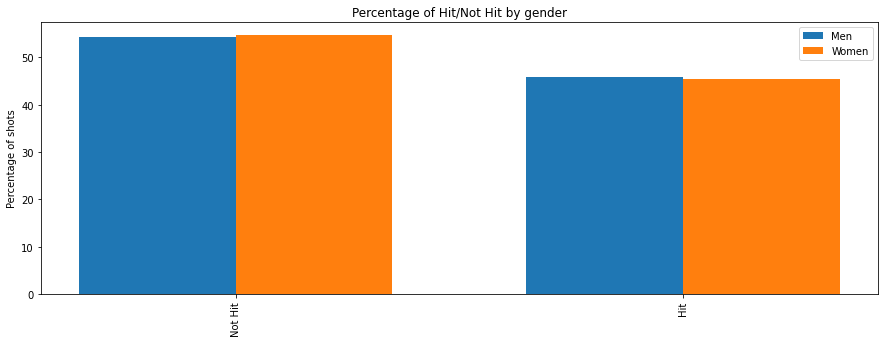

In [25]:
labels2 = ["Not Hit", "Hit"]
n_labels = len(labels2)
men_hit_pct = 100*(men_is_hit.values)/n_men
women_hit_pct = 100*(women_is_hit.values)/n_women

#The label locations
x2 = np.arange(n_labels)

width2 = 0.35

fig2, ax2 = plt.subplots(figsize=(15,5))
men_hit_plt = ax2.bar(x2-width2/2, men_hit_pct, width2, label='Men')
women_hit_plt = ax2.bar(x2 + width2/2, women_hit_pct, width2, label = 'Women')

ax2.set_ylabel("Percentage of shots")
ax2.set_title("Percentage of Hit/Not Hit by gender")
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2, rotation='vertical')
ax2.legend()

    从上图上看，男性运动员使用击打类技术的比例要多一点点，下面进行卡方检验

In [26]:
hit_cont_table = np.array([men_is_hit.values, women_is_hit.values])
hit_cont_table

array([[50511, 42601],
       [46371, 38447]])

In [27]:
chi2_contingency(hit_cont_table)

(3.1942410718519225,
 0.0738980626180239,
 1,
 array([[50699.02087338, 42412.97912662],
        [46182.97912662, 38635.02087338]]))

    由卡方检验可以看出，P=0.07>0.05，因此男女运动员在hit,no-hit上统计学没有显著性差异

## 二、通过冰壶位置分析
    上述通过投掷方式分析的两种方式分别在一定程度上否定了我们一开始的假设：男性更倾向于击打冰壶，接下来换一种分析的思路，使用场上剩余冰壶的数量，如果之前的假设成立，那么男性运动员比赛场上平均冰壶数量应该少于女性
    因此我们需要获取以下数据：
- 从game表中获取type
- 每一局(ends)场上冰壶的数量，从stone_position表中获取，我们需要通过sql语句来实现
    1. 计算每一局的冰壶数量
    2. 取最大值

In [28]:
q = """
WITH stone_counts AS
(SELECT shots.end_id, stone_positions.shot_id, COUNT(stone_positions.x) AS stone_count FROM stone_positions 
INNER JOIN shots ON shots.id = stone_positions.shot_id
GROUP BY shot_id)

SELECT games.type, MAX(stone_counts.stone_count) AS max_stones FROM stone_counts
INNER JOIN ends ON ends.id = stone_counts.end_id
INNER JOIN games ON games.id = ends.game_id
GROUP BY end_id
"""
stone_count_df = db.run_query(q)
stone_count_df

,type,max_stones
0,Men,5
1,Men,5
2,Men,6
3,Men,7
4,Men,7
...,...,...
11466,Women,8
11467,Women,3
11468,Women,9
11469,Women,3


In [29]:
men_max_stone_counts = stone_count_df[stone_count_df["type"] == "Men"]
women_max_stone_counts = stone_count_df[stone_count_df["type"] == "Women"]

In [30]:
n_men_ends = men_max_stone_counts.shape[0]
n_men_ends

5986

In [31]:
n_women_ends = women_max_stone_counts.shape[0]
n_women_ends

5485

    男女运动员的比赛数量差不多，接下来绘图细分

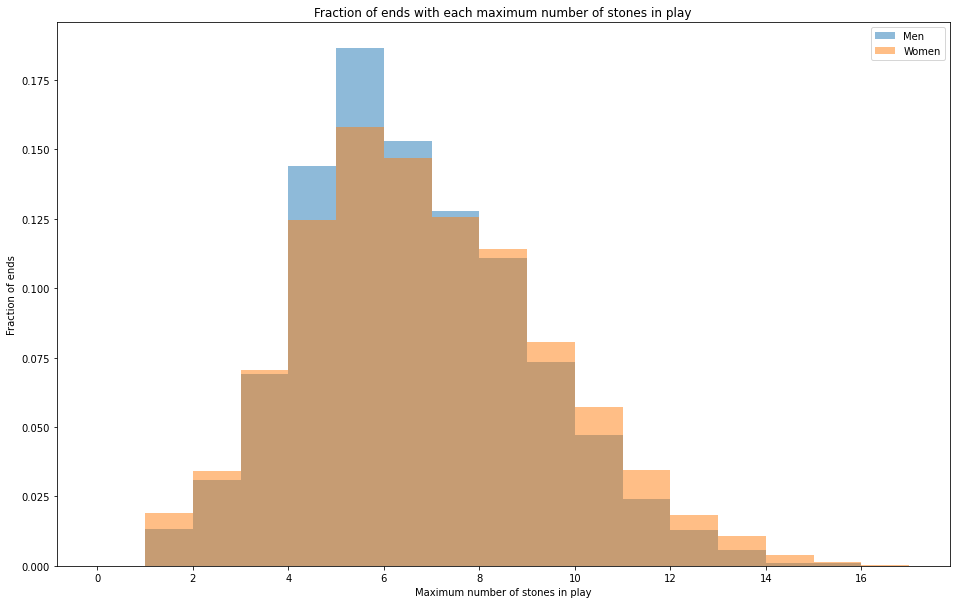

In [32]:
from matplotlib.ticker import MaxNLocator

fig3, ax3 = plt.subplots(figsize=(16,10))
men_max_plt = plt.hist(men_max_stone_counts["max_stones"], density=True, bins=np.arange(0,18),alpha=0.5, label="Men")
women_max_plt = plt.hist(women_max_stone_counts["max_stones"], density=True, bins=np.arange(0,18),alpha=0.5, label="Women")
ax3.set_ylabel("Fraction of ends")
ax3.set_xlabel("Maximum number of stones in play")
ax3.set_title("Fraction of ends with each maximum number of stones in play")
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.legend()

    由上图可以看出，女性运动员每一局场上存在的最大冰壶数量，总体分布大于男性运动员，并且差异较为明显，接下来我们用卡方检验来检验是否存在显著性差异

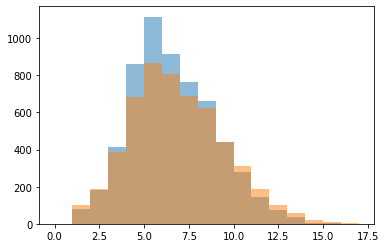

In [33]:
# 绘图没有使用density=True，即没有使用标准化（以频率表示），因此会有所不同
men_max_counts = plt.hist(men_max_stone_counts["max_stones"], bins=np.arange(0,18),alpha=0.5, label="Men")
women_max_counts = plt.hist(women_max_stone_counts["max_stones"], bins=np.arange(0,18),alpha=0.5, label="Women")

In [36]:
men_max_counts[0]

array([   0.,   79.,  184.,  413.,  862., 1116.,  916.,  764.,  664.,
        439.,  281.,  144.,   77.,   35.,    6.,    6.,    0.])

In [37]:
women_max_counts[0]

array([  0., 104., 188., 386., 684., 866., 806., 689., 626., 442., 313.,
       189., 101.,  59.,  22.,   8.,   2.])

In [38]:
# 卡方检验
max_cont = np.array([men_max_counts[0], women_max_counts[0]])
max_cont

array([[   0.,   79.,  184.,  413.,  862., 1116.,  916.,  764.,  664.,
         439.,  281.,  144.,   77.,   35.,    6.,    6.,    0.],
       [   0.,  104.,  188.,  386.,  684.,  866.,  806.,  689.,  626.,
         442.,  313.,  189.,  101.,   59.,   22.,    8.,    2.]])

In [39]:
# 需要删除一个零项，因为卡方检验无法处理零期望频率
max_cont = np.array([np.delete(men_max_counts[0], 0), np.delete(women_max_counts[0], 0)])
chi2_contingency(max_cont)

(75.28572410643835,
 5.027359752859968e-10,
 15,
 array([[9.54962950e+01, 1.94123616e+02, 4.16948304e+02, 8.06761050e+02,
         1.03428228e+03, 8.98604481e+02, 7.58230146e+02, 6.73170604e+02,
         4.59738994e+02, 3.09971581e+02, 1.73771947e+02, 9.28871066e+01,
         4.90527417e+01, 1.46114550e+01, 7.30572749e+00, 1.04367536e+00],
        [8.75037050e+01, 1.77876384e+02, 3.82051696e+02, 7.39238950e+02,
         9.47717723e+02, 8.23395519e+02, 6.94769854e+02, 6.16829396e+02,
         4.21261006e+02, 2.84028419e+02, 1.59228053e+02, 8.51128934e+01,
         4.49472583e+01, 1.33885450e+01, 6.69427251e+00, 9.56324645e-01]]))

    对于每一局场上冰壶最大数目男女运动员的分布情况，经过卡方检验后发现P<0.05接近于零，即直方图中男女差异在统计学上具有显著性差异
    但是，对于每一局来说（不是基于这些大量的数据）以观众来看，是否能够直观的感受到这个差异呢，接下来我们用10局比赛来验证下

In [40]:
men_game_max = 10*men_max_plt[0]
men_game_max

array([0.        , 0.13197461, 0.3073839 , 0.6899432 , 1.44002673,
       1.86435015, 1.53023722, 1.27631139, 1.10925493, 0.73337788,
       0.46942867, 0.24056131, 0.12863348, 0.05846976, 0.01002339,
       0.01002339, 0.        ])

In [41]:
women_game_max = 10*women_max_plt[0]
women_game_max

array([0.        , 0.18960802, 0.34275296, 0.70373747, 1.24703737,
       1.57885141, 1.46946217, 1.25615314, 1.14129444, 0.80583409,
       0.57064722, 0.34457612, 0.18413856, 0.10756609, 0.04010939,
       0.01458523, 0.00364631])

In [42]:
game_max_cont = np.array([np.delete(men_game_max, 0), np.delete(women_game_max, 0)])
chi2_contingency(game_max_cont)

(0.13043701956774909,
 0.9999999999999137,
 15,
 array([[0.16079131, 0.32506843, 0.69684033, 1.34353205, 1.72160078,
         1.49984969, 1.26623227, 1.12527468, 0.76960599, 0.52003794,
         0.29256871, 0.15638602, 0.08301793, 0.02506639, 0.01230431,
         0.00182315],
        [0.16079131, 0.32506843, 0.69684033, 1.34353205, 1.72160078,
         1.49984969, 1.26623227, 1.12527468, 0.76960599, 0.52003794,
         0.29256871, 0.15638602, 0.08301793, 0.02506639, 0.01230431,
         0.00182315]]))

    这次P值基本接近于1，也就是并没有显著性差异，那如果我们看100场比赛呢？

In [43]:
event_max_cont = np.array([np.delete(100*men_game_max, 0), np.delete(100*women_game_max, 0)])
chi2_contingency(event_max_cont)

(13.04370195677491,
 0.5989223044448491,
 15,
 array([[ 16.07913146,  32.50684292,  69.68403333, 134.35320518,
         172.16007816, 149.98496949, 126.62322691, 112.52746838,
          76.96059874,  52.00379433,  29.25687132,  15.63860189,
           8.30179261,   2.50663886,   1.23043102,   0.18231541],
        [ 16.07913146,  32.50684292,  69.68403333, 134.35320518,
         172.16007816, 149.98496949, 126.62322691, 112.52746838,
          76.96059874,  52.00379433,  29.25687132,  15.63860189,
           8.30179261,   2.50663886,   1.23043102,   0.18231541]]))

    这一次,p=0.6仍然大于0.05,也就是说如果通过一场赛事的观察，仍然无法通过场上冰壶数量的统计来判断男女
    
## 结论
    男女比赛在每局最大冰壶数量上存在显著性差异，但是这种差异并没有办法在一局比赛甚至一整场赛事中体现出来

- 男子和女子冰壶投掷方式差异（按技术细分和击打与非击打分类）
- 男子女子每局场上剩余冰壶的最大数量
通过这两种分析方法，结果均存在显著性差异，但就单局比赛而言，男性和女性之间并不会有显著性差异，对于以场赛事100局比赛来说，同样也没有显著性差异。

    目前的分析可能比较简单，无法挖掘更明显的差异。投壶方式是否与第几次投壶存在关系（第一次投壶往往是防守）？场上的比分是否会影响最后一投的决策？是更激进还是更保守？无论男女，领先的队伍都倾向于把场上清理干净而不是让场上形势变得更复杂，男女运动员的投壶准确度是否存在差异？这些都是影响结果的原因，值得我们进一步讨论研究。